In [1]:
import json

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import sklearn.neighbors as nb

import bachelors_thesis.util as util

In [2]:
data_path = "../../data"

In [3]:
## Load cameras
cameras = list()
with open(f"{data_path}/dataset/cameras.json", mode="r", encoding="utf-8") as file:
    for line in file:
        camera = json.loads(line)
        cameras.append({"camera_id": camera["camera_id"], "x": camera["position"][0], "y": camera["position"][1]})

## Assign records to cameras
cameras_dict = {camera["camera_id"]: camera for camera in cameras}

with open(f"{data_path}/dataset/records/records.json", mode="r", encoding="utf-8") as file:
    for line in file:
        record = json.loads(line)
        camera = cameras_dict[record["camera_id"]]
        if "records" in camera:
            camera["records"] += 1
        else:
            camera["records"] = 1

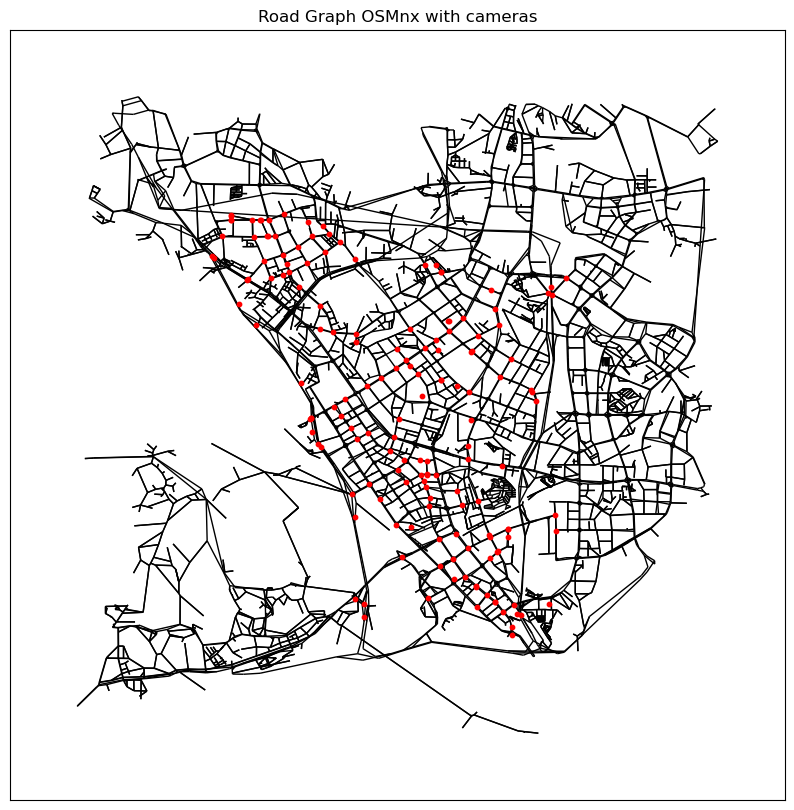

In [4]:
## Load OSMnx road graph
road_graph_ox = util.load_graph(f"{data_path}/road_graph/road_graph_ox_sim_con_35_nsl_sc.pickle")
road_graph_ox = ox.project_graph(road_graph_ox, to_crs=util.EPSG_32650)

## Project camera coordinates
for camera in cameras:
    x, y = camera["x"], camera["y"]
    proj_gps = util.xy_to_epsg4326(np.array([[x, y]]))
    proj_gps = util.epsg4326_to_epsg32650(proj_gps)
    lon, lat = proj_gps[0, 0], proj_gps[0, 1]
    camera["x"] = lon
    camera["y"] = lat

camera_coordinates = np.array([[camera["x"], camera["y"]] for camera in cameras])

## Draw cameras on road graph
pos = {node: (road_graph_ox.nodes[node]["x"], road_graph_ox.nodes[node]["y"]) for node in road_graph_ox.nodes()}

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
nx.draw_networkx_edges(
    road_graph_ox,
    pos,
    arrows=False,
    ax=ax
)
ax.scatter(camera_coordinates[:, 0], camera_coordinates[:, 1], s=10, c="red")
ax.set_title("Road Graph OSMnx with cameras")

plt.savefig(f"{data_path}/road_graph/road_graph_ox_sim_con_35_nsl_sc_cameras.svg")
plt.show()

Median distance from camera to nearest node:  8.954999236549284


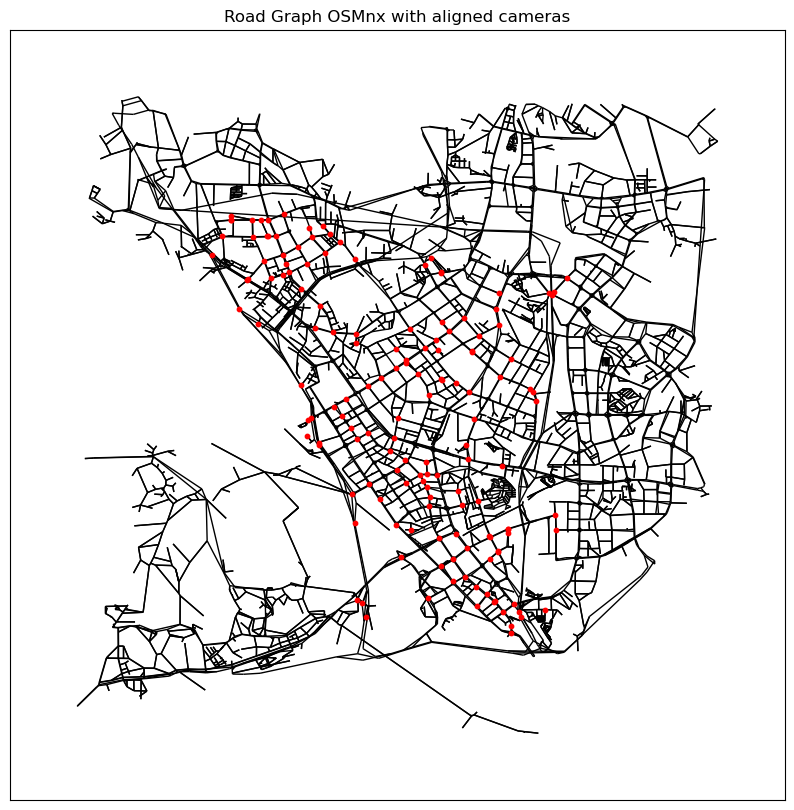

In [5]:
## Match cameras to nearest node
nodes = [{"node_id": node, "x": road_graph_ox.nodes[node]["x"], "y": road_graph_ox.nodes[node]["y"]} for node in
         road_graph_ox.nodes()]
node_coordinates = np.array([[node["x"], node["y"]] for node in nodes])

tree = nb.KDTree(node_coordinates)
distances, indices = tree.query(camera_coordinates, k=1, return_distance=True)
print("Median distance from camera to nearest node: ", np.median(distances))
indices = indices.flatten()

for index, camera in zip(indices, cameras):
    camera["node_id"] = nodes[index]["node_id"]

# Save camera info
util.save(cameras_dict, f"{data_path}/road_graph/road_graph_ox_sim_con_35_nsl_sc_cameras.pickle")

camera_nodes = {camera["node_id"] for camera in cameras}
camera_node_coordinates = np.array(
    [[road_graph_ox.nodes[camera_node]["x"], road_graph_ox.nodes[camera_node]["y"]] for camera_node in camera_nodes])

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
nx.draw_networkx_edges(
    road_graph_ox,
    pos,
    arrows=False,
    ax=ax
)
ax.scatter(camera_node_coordinates[:, 0], camera_node_coordinates[:, 1], s=10, c="red")
ax.set_title("Road Graph OSMnx with aligned cameras")

plt.savefig(f"{data_path}/road_graph/road_graph_ox_sim_con_35_nsl_sc_cameras_aligned.svg")
plt.show()